In [39]:
import os
import sys

sys.path.append(os.path.abspath(os.path.dirname(os.path.dirname(os.path.join(os.getcwd())))))

import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from data_utils.utils import keep_existing_photos, downsample_group
from data_utils.dataset import (
    PhotoLabelDataset,
    stratified_split_dataset,
    train_transform,
    val_transform,
)
from model.resnet18 import Resnet18FineTuneModel
from model.utils import (
    get_device,
    train_model_single_epoch,
    validate_model_single_epoch,
    save_checkpoint,
    evaluate_on_test,
    plot_history,
)

### Data preprocessing

In [4]:
base_dir = "../../"

business_df = pd.read_json(f'{base_dir}data/yelp_dataset/yelp_academic_dataset_business.json', lines=True)
photos_df = pd.read_json(f'{base_dir}data/yelp_photos/photos.json', lines=True)

photo_dir = f"{base_dir}data/yelp_photos/resized_photos"
photos_df = keep_existing_photos(photos_df, photo_dir)

photos_df = photos_df[photos_df['label'] == 'food'].copy()

categories_df = business_df[['business_id', 'attributes']].copy()
photos_df = photos_df.merge(categories_df, on="business_id", how="left")

photos_df = photos_df[photos_df['attributes'].notna()]
photos_df['price_range'] = photos_df['attributes'].apply(lambda x: x.get('RestaurantsPriceRange2'))

photos_df['price_range'] = photos_df['price_range'].astype(int)
photos_df['price_range'] = photos_df['price_range'].replace({2: 1, 3: 2, 4: 2}) # Binary classification
photos_df.price_range.value_counts()

Checking images: 100%|██████████| 200100/200100 [00:05<00:00, 39759.94it/s]


price_range
1    88822
2     8107
Name: count, dtype: int64

In [5]:
# Downsample to get balanced dataset
price_2_num = (photos_df.price_range == 2).sum()

food_df = photos_df.groupby('price_range', group_keys=False).apply(
    lambda x: downsample_group(x, price_2_num) if x.name in [1] else x  # Only downsample for price_range 1 and 2
)

food_df['price_range'] = food_df['price_range'] - 1

/var/folders/6n/sm2tfzkn2hjd8cpfn_256ph00000gp/T/ipykernel_45534/1009235296.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  food_df = photos_df.groupby('price_range', group_keys=False).apply(


In [6]:
food_df.price_range.value_counts()

price_range
0    8107
1    8107
Name: count, dtype: int64

In [27]:
label = 'price_range'

price_dataset = PhotoLabelDataset(food_df, photo_dir, label)
labels = food_df[label].values 
train_size = 0.85
val_size = 0.10

train_dataset, val_dataset, test_dataset = stratified_split_dataset(
    price_dataset,
    labels,
    train_size=train_size,
    val_size=val_size,
    random_state=42
)

train_dataset.transform = train_transform
val_dataset.transform = val_transform
test_dataset.transform = val_transform

batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

for images, labels in train_loader:
    print("Images shape:", images.shape)  
    print("Labels shape:", labels.shape)
    break

Images shape: torch.Size([64, 3, 224, 224])
Labels shape: torch.Size([64])


### Model training

In [28]:
num_classes = 2
device = get_device()

model = Resnet18FineTuneModel(num_classes=num_classes)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
scaler = torch.amp.GradScaler("cuda")
grad_clip = 1
ckpt_dir = "checkpoints/price_2_classes"

history = {
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": []
}

# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, device, scaler, grad_clip, history, ckpt_dir, num_epochs=10):
    model.train()

    for epoch in range(1, num_epochs+1):
        train_loss, train_accuracy = train_model_single_epoch(
            model, train_loader, criterion, optimizer, device, scaler, grad_clip
        )
        val_loss, val_accuracy = validate_model_single_epoch(model, val_loader, criterion, device)

        print(
            f"[Epoch {epoch}/{num_epochs}]",
            f"Train Loss: {train_loss:.4f} | " f"Train Accuracy: {train_accuracy:.4f}",
            f"Val Loss: {val_loss:.4f} | " f"Val Accuracy: {val_accuracy:.4f}"
        )

        history["train_loss"].append(train_loss)
        history["train_accuracy"].append(train_accuracy)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_accuracy)

        save_checkpoint(epoch, model, optimizer, history, ckpt_dir)

/Users/ericxia/Library/Caches/pypoetry/virtualenvs/food-classification-nES7ttkF-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ericxia/Library/Caches/pypoetry/virtualenvs/food-classification-nES7ttkF-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/ericxia/Library/Caches/pypoetry/virtualenvs/food-classification-nES7ttkF-py3.10/lib/python3.10/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  

In [29]:
num_epochs = 20
train_model(model, train_loader, val_loader, criterion, optimizer, device, scaler, grad_clip, history, ckpt_dir, num_epochs=num_epochs)

Training: 100%|██████████| 216/216 [00:29<00:00,  7.41it/s, loss=0.285]


[Epoch 1/20] Train Loss: 0.5866 | Train Accuracy: 0.7088 Val Loss: 0.5753 | Val Accuracy: 0.7256
Model checkpoint saved at checkpoints/price_2_classes/ckpt_1


Training: 100%|██████████| 216/216 [00:29<00:00,  7.28it/s, loss=0.805]


[Epoch 2/20] Train Loss: 0.4781 | Train Accuracy: 0.7730 Val Loss: 0.5716 | Val Accuracy: 0.7219
Model checkpoint saved at checkpoints/price_2_classes/ckpt_2


Training: 100%|██████████| 216/216 [00:30<00:00,  7.12it/s, loss=0.38] 


[Epoch 3/20] Train Loss: 0.3757 | Train Accuracy: 0.8331 Val Loss: 0.5509 | Val Accuracy: 0.7318
Model checkpoint saved at checkpoints/price_2_classes/ckpt_3


Training: 100%|██████████| 216/216 [00:35<00:00,  6.06it/s, loss=0.277] 


[Epoch 4/20] Train Loss: 0.2398 | Train Accuracy: 0.9052 Val Loss: 0.7280 | Val Accuracy: 0.7201
Model checkpoint saved at checkpoints/price_2_classes/ckpt_4


Training: 100%|██████████| 216/216 [00:34<00:00,  6.19it/s, loss=0.329] 


[Epoch 5/20] Train Loss: 0.1332 | Train Accuracy: 0.9509 Val Loss: 1.2403 | Val Accuracy: 0.7269
Model checkpoint saved at checkpoints/price_2_classes/ckpt_5


Training: 100%|██████████| 216/216 [00:35<00:00,  6.06it/s, loss=0.224] 


[Epoch 6/20] Train Loss: 0.0915 | Train Accuracy: 0.9657 Val Loss: 1.1077 | Val Accuracy: 0.7374
Model checkpoint saved at checkpoints/price_2_classes/ckpt_6


Training: 100%|██████████| 216/216 [00:34<00:00,  6.28it/s, loss=0.0171] 


[Epoch 7/20] Train Loss: 0.0704 | Train Accuracy: 0.9757 Val Loss: 1.4216 | Val Accuracy: 0.7072
Model checkpoint saved at checkpoints/price_2_classes/ckpt_7


Training: 100%|██████████| 216/216 [00:33<00:00,  6.44it/s, loss=0.157]  


[Epoch 8/20] Train Loss: 0.0539 | Train Accuracy: 0.9807 Val Loss: 1.1177 | Val Accuracy: 0.7361
Model checkpoint saved at checkpoints/price_2_classes/ckpt_8


Training: 100%|██████████| 216/216 [00:32<00:00,  6.58it/s, loss=0.00303]


[Epoch 9/20] Train Loss: 0.0472 | Train Accuracy: 0.9829 Val Loss: 1.3523 | Val Accuracy: 0.7244
Model checkpoint saved at checkpoints/price_2_classes/ckpt_9


Training: 100%|██████████| 216/216 [00:33<00:00,  6.38it/s, loss=0.115]  


[Epoch 10/20] Train Loss: 0.0365 | Train Accuracy: 0.9865 Val Loss: 1.5500 | Val Accuracy: 0.7256
Model checkpoint saved at checkpoints/price_2_classes/ckpt_10


Training: 100%|██████████| 216/216 [00:45<00:00,  4.70it/s, loss=0.0192]  


[Epoch 11/20] Train Loss: 0.0398 | Train Accuracy: 0.9852 Val Loss: 1.4367 | Val Accuracy: 0.7454
Model checkpoint saved at checkpoints/price_2_classes/ckpt_11


Training: 100%|██████████| 216/216 [00:43<00:00,  4.98it/s, loss=0.143]   


[Epoch 12/20] Train Loss: 0.0368 | Train Accuracy: 0.9869 Val Loss: 1.6620 | Val Accuracy: 0.7300
Model checkpoint saved at checkpoints/price_2_classes/ckpt_12


Training: 100%|██████████| 216/216 [00:43<00:00,  5.02it/s, loss=0.0412]  


[Epoch 13/20] Train Loss: 0.0352 | Train Accuracy: 0.9876 Val Loss: 1.6064 | Val Accuracy: 0.7096
Model checkpoint saved at checkpoints/price_2_classes/ckpt_13


Training: 100%|██████████| 216/216 [00:45<00:00,  4.79it/s, loss=0.541]   


[Epoch 14/20] Train Loss: 0.0327 | Train Accuracy: 0.9893 Val Loss: 1.3892 | Val Accuracy: 0.7330
Model checkpoint saved at checkpoints/price_2_classes/ckpt_14


Training: 100%|██████████| 216/216 [00:45<00:00,  4.78it/s, loss=0.000196]


[Epoch 15/20] Train Loss: 0.0275 | Train Accuracy: 0.9900 Val Loss: 1.7872 | Val Accuracy: 0.7182
Model checkpoint saved at checkpoints/price_2_classes/ckpt_15


Training: 100%|██████████| 216/216 [00:43<00:00,  4.97it/s, loss=0.121]   


[Epoch 16/20] Train Loss: 0.0292 | Train Accuracy: 0.9891 Val Loss: 1.6064 | Val Accuracy: 0.7374
Model checkpoint saved at checkpoints/price_2_classes/ckpt_16


Training: 100%|██████████| 216/216 [00:37<00:00,  5.70it/s, loss=0.257]   


[Epoch 17/20] Train Loss: 0.0326 | Train Accuracy: 0.9875 Val Loss: 1.5483 | Val Accuracy: 0.7398
Model checkpoint saved at checkpoints/price_2_classes/ckpt_17


Training: 100%|██████████| 216/216 [00:31<00:00,  6.85it/s, loss=0.00288] 


[Epoch 18/20] Train Loss: 0.0296 | Train Accuracy: 0.9879 Val Loss: 1.5398 | Val Accuracy: 0.7244
Model checkpoint saved at checkpoints/price_2_classes/ckpt_18


Training: 100%|██████████| 216/216 [00:33<00:00,  6.53it/s, loss=0.00206] 


[Epoch 19/20] Train Loss: 0.0253 | Train Accuracy: 0.9903 Val Loss: 1.7409 | Val Accuracy: 0.7324
Model checkpoint saved at checkpoints/price_2_classes/ckpt_19


Training: 100%|██████████| 216/216 [00:30<00:00,  7.11it/s, loss=0.183]   


[Epoch 20/20] Train Loss: 0.0209 | Train Accuracy: 0.9922 Val Loss: 1.9276 | Val Accuracy: 0.7059
Model checkpoint saved at checkpoints/price_2_classes/ckpt_20


### Model evaluation

In [37]:
ckpt = torch.load(f"{base_dir}saved_models/price_binary/ckpt_20")
model = Resnet18FineTuneModel(num_classes=num_classes)
model.load_state_dict(ckpt['model_state_dict'])
model.to(device)
model.eval()

/Users/ericxia/Library/Caches/pypoetry/virtualenvs/food-classification-nES7ttkF-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ericxia/Library/Caches/pypoetry/virtualenvs/food-classification-nES7ttkF-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Resnet18FineTuneModel(
  (base): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [38]:
classification_report = evaluate_on_test(model, test_loader, device, ['0', '1'])

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.71      0.82      0.76       406
           1       0.78      0.67      0.72       405

    accuracy                           0.74       811
   macro avg       0.75      0.74      0.74       811
weighted avg       0.75      0.74      0.74       811



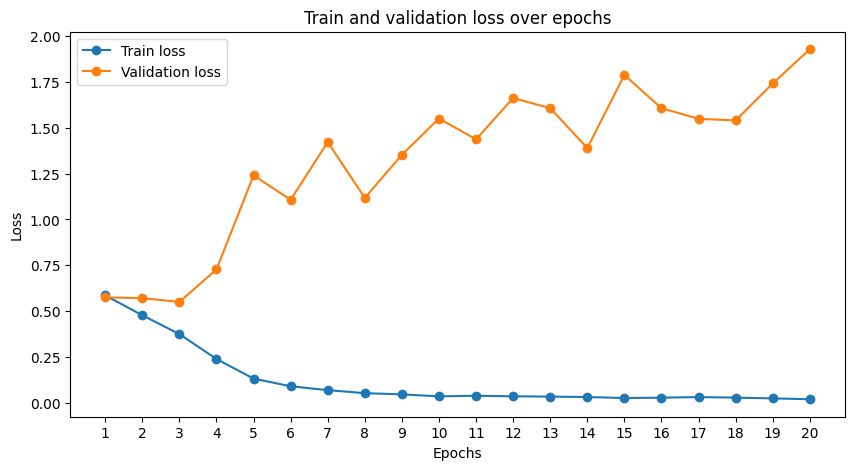

In [35]:
ckpt_last = torch.load(f"{base_dir}saved_models/price_binary/ckpt_20")
history = ckpt_last['history']
plot_history(history, 'loss')

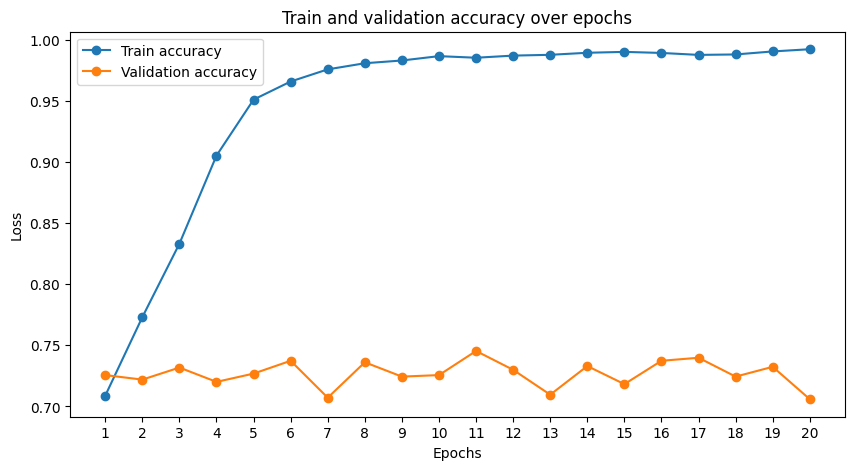

In [36]:
plot_history(history, 'accuracy')